# konlpy & Metab 설치

In [ ]:
!pip install konlpy

In [ ]:
!pip show konlpy

Name: konlpy
Version: 0.5.2
Summary: Python package for Korean natural language processing.
Home-page: http://konlpy.org
Author: Team KoNLPy
Author-email: konlpy@googlegroups.com
License: GPL v3
Location: /usr/local/lib/python3.7/dist-packages
Requires: beautifulsoup4, numpy, tweepy, colorama, lxml, JPype1
Required-by: 


In [ ]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Total 91 (delta 0), reused 0 (delta 0), pack-reused 91
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
  Using cached konlpy-0.5.2-py2.py3-none-any.whl (19.4 MB)
  Using cached JPype1-1.3.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (448 kB)
  Using cached beautifulsoup4-4.6.0-py3-none-any.whl (86 kB)
  Using cached colorama-0.4.4-py2.py3-none-any.whl (16 kB)
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-12-28 01:48:32--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff

# 네이버 쇼핑 리뷰 데이터 전처리
* 대상 데이터 : 네이버 쇼핑 리뷰 데이터
* 총 200,000개의 리뷰로 구성된 데이터
* 5점 만점에 1점, 2점, 4점, 5점인 리뷰들로 구성
* 3점 : 긍부정 유무가 애매하여 데이터 구성 시 제외됨

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import konlpy
import tensorflow as tf
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 데이터 로드

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f26e2505d50>)

In [ ]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])

print('전체 리뷰 개수 :', len(total_data)) # 전체 리뷰 개수 출력
print('5점 리뷰 개수 :', len(total_data[total_data.ratings == 5])) # 5점 리뷰 개수 출력
print('4점 리뷰 개수 :', len(total_data[total_data.ratings == 4])) # 4점 리뷰 개수 출력
print('2점 리뷰 개수 :', len(total_data[total_data.ratings == 2])) # 2점 리뷰 개수 출력
print('1점 리뷰 개수 :', len(total_data[total_data.ratings == 1])) # 1점 리뷰 개수 출력

전체 리뷰 개수 : 200000
5점 리뷰 개수 : 81177
4점 리뷰 개수 : 18786
2점 리뷰 개수 : 63989
1점 리뷰 개수 : 36048


In [ ]:
total_data.head(5)

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


## train / test data 분리
Labeling : 긍정(1), 부정(0)

In [ ]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default = 0)
total_data.head(5)

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


각 열에 대해 중복 제외

In [ ]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

* ratings : 4가지 값 (1점, 2점, 4점, 5점)
* reviews : 중복 제외하면 199,908개
* label : 2가지 값 (0, 1)

In [ ]:
total_data.drop_duplicates(subset = ['reviews'], inplace = True) # reviews 열에서 중복 제거

print('총 샘플의 개수 :', len(total_data))

총 샘플의 개수 : 199908


NULL 값 유무 확인

In [ ]:
print(total_data.isnull().values.any())

False


train : test = 3 : 1 비율로 분리

In [ ]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)

print('train용 리뷰 개수 :', len(train_data))
print('test용 리뷰 개수 :', len(test_data))

train용 리뷰 개수 : 149931
test용 리뷰 개수 : 49977


## label 분포 확인

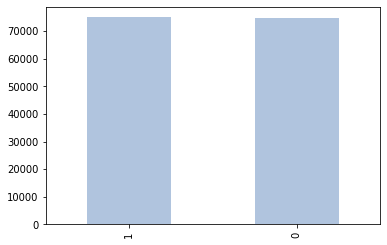

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar', color = 'lightsteelblue')

In [ ]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74918
1      1  75013


* 두 label 모두 약 7만 5천개로 50:50 비율 

## 데이터 정제하기
* 정규표현식 사용하여 한글을 제외하고 모두 제거
* 빈 샘플 생기는지 확인

In [ ]:
# train : 한글 & 공백 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규표현식 수행
train_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null값으로 변경
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


In [ ]:
# test : 한글과 공백을 제외하고 모두 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how = 'any') # Null값 제거
print('전처리 후 test용 샘플의 개수 :', len(test_data))

전처리 후 test용 샘플의 개수 : 49977


## 토큰화
형태소 분석기 Mecab을 사용하여 토큰화 작업 진행

In [ ]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


불용어 지정

In [ ]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에',
             '하', '고', '을', '를', '인', '듯', '과', '와', '네',
             '들', '듯', '지', '임', '게']

In [ ]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

## 단어 & 길이 분포 확인
긍정 리뷰 / 부정 리뷰에는 주로 어떤 단어가 많이 등장하는지 빈도수 계산

In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20)) # 부정 리뷰에 대해 빈도수가 높은 상위 20개 단어 출력

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20)) # 긍정 리뷰에 대해 빈도수가 높은 상위 20개 단어 출력

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


길이 분포 확인

긍정 리뷰의 평균 길이 : 13.587751456414221
부정 리뷰의 평균 길이 : 17.029525614672043


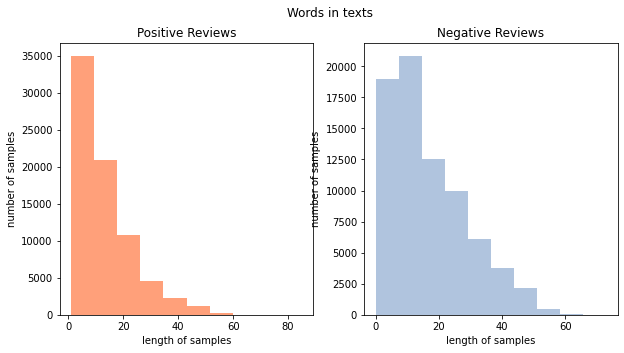

In [ ]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
text_len = train_data[train_data['label'] == 1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color = 'lightsalmon')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label'] == 0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color = 'lightsteelblue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

* 긍정 리뷰보다는 부정 리뷰가 좀 더 길게 작성된 경향이 있는 듯 보임

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

## 정수 인코딩
기계가 텍스트를 숫자로 처리할 수 있도록 데이터에 정수 인코딩 작업 필요

1) train data : 단어 집합(vocaburary) 만들기 

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train

array([list(['사이즈', '센치', '씩', '늘린', '건데', '작', '아요', '그리고', '색상', '완전', '달라요', '칙칙', '핑크', '네요', 'ㅠㅠ', '많이', '아쉽', '지만', '암막', '효과', '좋', '아요']),
       list(['ㅂ', '불', '만족', '빗이', '아픔', '멍', '피부', '빗', '질', '못해', '주', '겟', '네요']),
       list(['제품', '쓰', '삼', '일', '만', '변기', '물', '잘', '안', '내려갔', '어요', '혹시나', '해서', '다시', '빼', '보', '니', '물', '다시', '잘', '내려가', '네요', '많', '걸', '어쩌', '나요', '반품', '싶']),
       ..., list(['장', '주문', '안', '됩니다', '장', '가능', '해요']),
       list(['하림', '치킨', '여기', '서', '구입', '니', '엄청', '저렴', '네요', '배송', '쾅', '꽝', '얼', '어서', '도착', '아주', '만족', '합니다', 'ㅋㅋ']),
       list(['조금', '약해', '보이', '는데', '저렴', '잘', '삿', '어요'])], dtype=object)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39997
등장 빈도가 1번 이하인 희귀 단어의 수: 18212
단어 집합에서 희귀 단어의 비율: 45.53341500612546
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.79352492030765


* 약 40,000개 단어 존재
* 등장 빈도가 1회인 단어들 : 단어 집합에서 약 45%
* 실제 train data에서 등장 빈도가 1회인 단어들 : 약 0.8%
* 등장 빈도가 1회인 단어들은 자연어 처리에서 별로 중요하지 않은 듯 함 --> 정수 인코딩 과정에서 배제할 것

2) 등장 빈도수가 1인 단어들을 제외한 단어의 개수 = max(단어 집합의 크기)

In [ ]:
# 전체 단어 개수 중 빈도수가 1인 단어 개수 제거함
# 0번 패딩 토큰 & 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 21787


3) 위의 단어 집합을 토크나이저의 인자로 넘겨주면, 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환

이러한 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환

In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[67, 2060, 299, 14260, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2], [46, 24, 825, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]


In [ ]:
print(X_test[:3])

[[14, 704, 767, 116, 186, 252, 12], [339, 3904, 62, 3816, 1651], [11, 69, 2, 49, 164, 3, 27, 15, 6, 513, 289, 17, 92, 110, 564, 59, 7, 2]]


## 패딩
서로 다른 길이를 가진 샘플들의 길이를 동일하게 맞추는 패딩 작업 진행

1) 전체 데이터에서 가장 길이가 긴 리뷰 & 전체 데이터 길이의 분포 확인

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.30754813881052


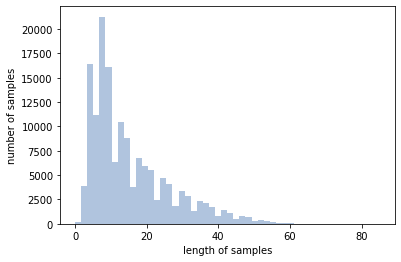

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins = 50, color = 'lightsteelblue')
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* 그래프로 봤을 때, 전체적으로는 60이하의 길이를 가지는 것으로 보임

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

2) 최대 길이가 85이므로 만약 80으로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있는지 확인

In [ ]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


* train용 리뷰의 99.99%가 80이하의 길이를 가짐 --> train용 리뷰를 길이 80으로 패딩

# BiLSTM 네이버 쇼핑 리뷰 감성 분류
* 양방향 LSTM : 두 개의 독립적인 LSTM 아키텍처를 함께 사용하는 구조
* 뒤의 문맥까지 고려하기 위해 오른쪽부터 읽는 역방향의 LSTM을 함께 사용
* 정방향 LSTM : 마지막 시점의 은닉 상태 반환
* 역방향 LSTM : 첫 번째 시점의 은닉 상태 반환

In [ ]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
embedding_dim = 100
hidden_units = 128


model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))
  
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
  
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

In [ ]:
# 테스트 정확도 확인
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

OSError: ignored

# 리뷰 예측

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩

  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

NameError: ignored

In [ ]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

# 네이버 영화 리뷰 데이터

### 데이터 로드

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f26b01a2190>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
print('train용 리뷰 개수 :',len(train_data)) # train용 리뷰 개수 출력

train용 리뷰 개수 : 150000


In [ ]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


* 데이터는 id, document, label 총 3개의 열로 구성
* id : 감성 분류를 수행하는데 도움이 되지 않으므로 무시
* 이 모델은 리뷰 내용을 담고있는 document와 해당 리뷰가 긍정(1), 부정(0)인지를 나타내는 label 두 개의 열을 학습하는 것

In [ ]:
print('test용 리뷰 개수 :',len(test_data)) # test용 리뷰 개수 출력

test용 리뷰 개수 : 50000


In [ ]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
# test 데이터에서 랜덤으로 20000만개 추출
test_data = test_data.sample(20000)

## 데이터 정제하기

In [ ]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

* 총 150,000개 샘플 존재
* document에서 중복 제거한 샘플 개수 : 146,182개 (약 4,000개 중복 샘플 존재)

각 열의 대해 중복 제외

In [ ]:
train_data.drop_duplicates(subset = ['document'], inplace = True) # 열에서 중복 제거

In [ ]:
print('총 샘플의 수 :', len(train_data))

총 샘플의 수 : 146183


## label 분포 확인

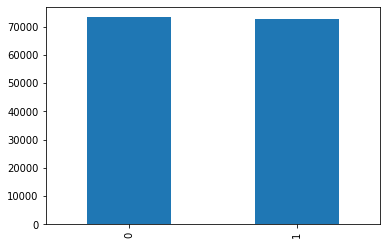

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')

* 두 label 모두 약 7만 2천개
* label 0인 리뷰가 근소하게 더 많음

Null 값 유무 확인

In [ ]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


* document 열에서 Null 값을 가진 샘플 1개 존재

Null 값을 가진 샘플이 어느 인덱스에 존재하는지 출력

In [ ]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


Null 값 제거

In [ ]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [ ]:
print(len(train_data)) # 총 샘플의 개수 -1만큼 변화

146182


정규표현식 사용하여 한글을 제외하고 모두 제거

In [ ]:
# 한글 & 공백 제외하고 모두 제거 
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
train_data[:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


train_data에 공백만 있거나, 빈 값을 가진 행이 있다면 Null 값으로 변경 후 Null 값 유무 확인

In [ ]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # 공백을 empty value로 변경
train_data['document'].replace('', np.nan, inplace = True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


* Null 값 789개 새로 생성

Null 값 존재하는 행 5개 출력

In [ ]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


* Null 값들은 긍정일수도, 부정일수도 있음
* 아무런 의미가 없는 데이터이므로 제거

In [ ]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


* 총 샘플 수 : 145393개

In [ ]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 19625


## 토큰화

불용어 제거

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

토큰화를 위한 형태소 분석기는 KoNLPy의 Okt를 사용

In [ ]:
okt = Okt()

NameError: ignored

In [ ]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

NameError: ignored

In [ ]:
print(X_train[:3])

In [ ]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

## 정수 인코딩

1) train data : 단어 집합(vocaburary) 만들기

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

* 등장 빈도가 2회 이하인 단어들 : 절반 이상을 차지
* 하지만, 실제로 trian data에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 1.87%
* 아무래도 등장 빈도가 2회 이하인 단어들은 자연어 처리에서 별로 중요하지 않은 듯 함 -> 정수 인코딩 과정에서 배제할 것

2) 등장 빈도수가 2이하인 단어들을 제외한 단어의 개수 = max(단어 집합의 크기)

In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

* 단어 집합의 크기 : 19,416개

3) 위의 단어 집합을 토크나이저의 인자로 넘겨주면, 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환

이러한 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환

In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)print(X_train[:3])

In [ ]:
print(X_train[:3])

0번 단어 ~ 19,415번 단어까지만 사용 (0번 단어는 패딩을 위한 토큰)

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 빈 샘플(empty samples) 제거

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

## 패딩

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

* 분포 그래프를 봤을 때, max_len = 30이 적당할 것 같음
* 이 값이 얼마나 많은 리뷰 길이를 커버하는지 확인

In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)

In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)